In [1]:
clear all;

global ipynb = 'ttt-vfun';

source('clearest-nn.m');
source('utils-logging.m');
source('utils-training.m');
source('game-ttt.m');

% log2file(tmp('log'));

##########################################

[winner,s] = play1(@randompolicy, @randompolicy)
oh18 = game2oh18(s)'
oh27 = game2oh27(s)'
play(100, @randompolicy);


ans = THE CLEAREST NEURAL NETWORK FRAMEWORK BY UNDWAD
ans = TIC-TAC-TOE GAME
winner =  2
s =

   0   2   2
   1   1   2
   1   1   2

oh18 =

   0   0   1   0   1   0   0   1   1   0   1   0   0   1   0   1   0   1

oh27 =

 Columns 1 through 26:

  1  0  0  0  0  0  0  0  0  0  1  1  0  1  1  0  0  0  0  0  0  1  0  0  1  1

 Column 27:

  1

playing 100 times randompolicy vs randompolicy
wins = [59 29]
draws = 12


<img align="left" src="assets/reinforce.png">
<img align="left" src="assets/reinforce-baseline.png">

vmodel.num_p = 721
winner =  1
s =

   1   1   2
   1   2   2
   1   2   1

winner =  1
s =

   1   1   1
   0   2   0
   2   1   2

playing 100 times randompolicy vs randompolicy
wins = [53 31]
draws = 16
playing 100 times randompolicy vs stochasticpolicy
wins = [55 23]
draws = 22
playing 100 times randompolicy vs deterministicpolicy
wins = [42 45]
draws = 13

datestr(starts_at) = 14-Jun-2020 14:47:26

player 2, episode 996 of 1000 (ok 716), gradnorm 0.019768, updratio 0.001287, wins [582 280], error 0.105041 ↓, ratio 0.481100 ↓
datestr(ends_at) = 14-Jun-2020 14:49:47
duration = [0 0 0 0 2 20.022681]

playing 100 times randompolicy vs stochasticpolicy
wins = [51 34]
draws = 15
playing 100 times randompolicy vs deterministicpolicy
wins = [42 52]
draws = 6


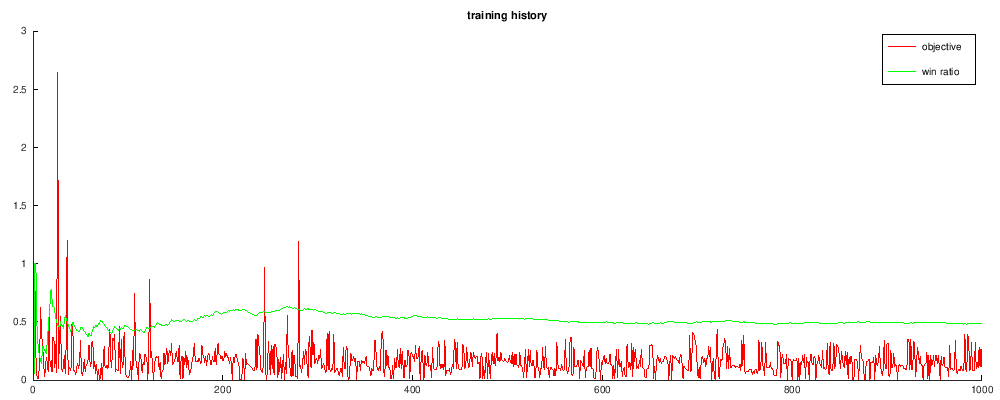

In [2]:
global vmodel epsilon tau gamma agentpolicy rivalpolicy;

function X = nextstates2onehots(s, aaa=actions(s))
    X = map(@(a) game2oh18(game(s,a)), aaa);
end

function a = stochasticpolicy(s)
    global vmodel;
    aaa     = actions(s);
    X       = nextstates2onehots(s, aaa);
    [~,Q]   = forward(vmodel, X);
    [~,~,i] = softmaxpick(Q');
    a       = aaa(i);
end

function a = deterministicpolicy(s)
    global vmodel;
    aaa   = actions(s);
    X     = nextstates2onehots(s, aaa);
    [~,Q] = forward(vmodel, X);
    [~,i] = max(Q);
    a     = aaa(i);
end

function [a,x,p] = taustochasticpolicy(s)
    global vmodel tau;
    aaa     = actions(s);
    X       = nextstates2onehots(s, aaa);
    [~,Q]   = forward(vmodel, X);
    Q      /= tau;
    [~,p,i] = softmaxpick(Q');
    a       = aaa(i);
    x       = X(:,i);
end

function [a,x,p] = epsilongreedypolicy(s)
    global vmodel epsilon;
    aaa = actions(s)
    X   = nextstates2onehots(s, aaa);
    if rand() < epsilon
        i     = randi([1 count(aaa)]);
        p     = epsilon;
    else
        [~,Q] = forward(vmodel, X);
        [~,i] = max(Q);
        p     = 1-epsilon;
    end
    a = aaa(i);
    x = X(:,i);
end

function [err,ok] = learnvalueapprox(X, Y)
    global vmodel;
    [vmodel,Z]     = forward(vmodel, X);
    E              = cost(vmodel, Z, Y);
    dE             = gradient(vmodel, Z, Y);
    [vmodel,ggg,~] = backward(vmodel, Z, dE);
    [vmodel,ggg]   = optimize_gradient(vmodel, ggg, 1);
    new_vmodel     = update(vmodel, ggg);
    err            = mean(E);
    [~,Z]          = forward(new_vmodel, X);
    E              = cost(new_vmodel, Z, Y);
    delta          = mean(E) - err;
    ok             = delta < 0;
    if ok
        vmodel = new_vmodel;
    end
end

function s = start(agent)
    global rivalpolicy;
    s = game();
    if agent == 2
        a = rivalpolicy(s);
        s = game(s, a); 
    end
end

function [s, reward, winner] = move(agent, s, a)
    global rivalpolicy;
    s = game(s, a);            # learning player moves
    if iswin(s, a)             # learning player wins
        reward = 1;
        winner = agent;
    elseif isover(s)           # draw
        reward = 0;
        winner = 0;
    elseif player(s) == agent  # invalid move
        error('invalid move');
    else                       # continue
        a = rivalpolicy(s);   
        s = game(s, a);        # other player moves
        if iswin(s, a)         # other player wins
            reward = -1;
            winner = player(s, a);
        elseif isover(s)       # draw
            reward = 0;
            winner = 0;
        else                   # continue
            reward = 0;
            winner = [];
        end  
    end  
end

function [winner,err,ok] = episode(agent)
    global agentpolicy gamma;
    winner = [];     # draw: 0, players: 1,2
    X = zeros(18,9); # states as onehot vectors
    Y = zeros(1,9);  # targets (rewards)
    P = zeros(1,9);  # chosen action probs
    n = 0;           # number of moves
    s = start(agent);
    do
        [a,x,p]           = agentpolicy(s);
        [s,reward,winner] = move(agent, s, a);
        n                += 1;
        X(:,n)            = x;
        Y(1,n)            = reward;
        P(1,n)            = p;
    until !isempty(winner);
    for i = n-1:-1:1
        Y(1,i) += gamma * P(1,i+1) * Y(1,i+1);
    end
    [err,ok] = learnvalueapprox(X(:,1:n), Y(:,1:n));
end

function ratio = iteration(p, n, eps=1e-8)
    global vmodel;
    ERROR = zeros(1,n);
    RATIO = zeros(1,n);
    OK    = 0; 
    wins  = [0 0];
    for t = 1:n
        [winner,err,ok] = episode(p);
        if winner > 0 
            wins(winner) += 1; 
        end
        if nnz(wins) == 2
            ratio = wins(p) / wins(other(p));
        else
            ratio = 0;
        end
        ERROR(t) = err;
        RATIO(t) = ratio;
        OK      += 1*ok;
        if t > 1 
            edir = sign(err   - ERROR(t-1));
            rdir = sign(ratio - RATIO(t-1));
        else
            edir = 0;
            rdir = 0;
        end
        gradnorm = getunit(vmodel.optimizers,'gradient_clipping').norm;
        updratio = getunit(vmodel.optimizers,'stats').ratio;        
        showlog(1, 100, 'player %d, episode %d of %d (ok %d), gradnorm %f, updratio %f, wins %s, error %f %s, ratio %f %s', 
                         p, t, n, OK, gradnorm, updratio, mat2str(wins), err, dir2arrow(edir), ratio, dir2arrow(rdir));
    end
    figure('Position', [0 0 1000 400]);
    hold on;
    plot(1:n, ERROR, 'r');
    plot(1:n, RATIO, 'g');
    legend('objective', 'win ratio')
    title('training history');
end

tau         = 10;
gamma       = 1;
epsilon     = 0.1;
rivalpolicy = @randompolicy;
agentpolicy = @taustochasticpolicy;
vmodel      = model(18, {'dense', 36}, 'relu', {'dense', 1});
% vmodel      = model(18, {'dense', 1});
vmodel      = optimization(vmodel, {'adam', 0.1},   {'gradient_clipping', 0.9}, 'stats');
vmodel      = objective(vmodel, 'mse');

printvar('vmodel.num_p');
%printmodel('vmodel');

[winner,s] = play1(@randompolicy, @stochasticpolicy)
[winner,s] = play1(@randompolicy, @deterministicpolicy)

play(100, @randompolicy);
play(100, @randompolicy, @stochasticpolicy);
play(100, @randompolicy, @deterministicpolicy);

printstart();
ratio = iteration(2, 1000);
printend();

play(100, @randompolicy, @stochasticpolicy);
play(100, @randompolicy, @deterministicpolicy);


In [ ]:
tau = 10;
printstart();
ratio = iteration(2, 10000);
printend(ipynb);

play(100, @randompolicy, @stochasticpolicy);
play(100, @randompolicy, @deterministicpolicy);


datestr(starts_at) = 14-Jun-2020 15:10:10

player 2, episode 9745 of 10000 (ok 6373), gradnorm 0.016149, updratio 0.001051, wins [5736 2800], error 0.112126  , ratio 0.488145 ↓


datestr(starts_at) = 14-Jun-2020 12:07:18

player 2, episode 9995 of 10000 (ok 6551), gradnorm 0.002320, updratio 0.000115, wins [5909 2821], error 0.143855  , ratio 0.477407 ↓
datestr(ends_at) = 14-Jun-2020 12:31:52
duration = [0 0 0 0 24 34.551595]
notifed = 1

playing 100 times randompolicy vs stochasticpolicy
wins = [62 24]
draws = 14
playing 100 times randompolicy vs deterministicpolicy
wins = [52 45]
draws = 3


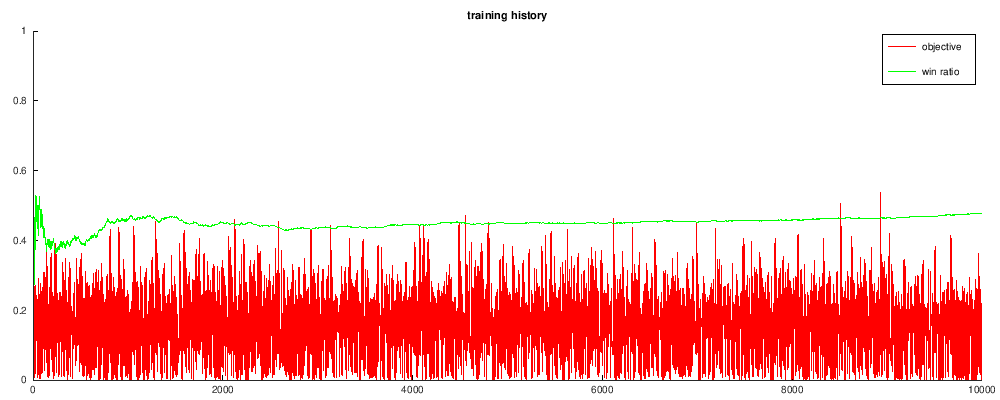

In [4]:
tau = 5;
printstart();
ratio = iteration(2, 10000);
printend(ipynb);

play(100, @randompolicy, @stochasticpolicy);
play(100, @randompolicy, @deterministicpolicy);


datestr(starts_at) = 14-Jun-2020 12:32:21

player 2, episode 9994 of 10000 (ok 6456), gradnorm 0.003482, updratio 0.000172, wins [5897 2848], error 0.074994 ↓, ratio 0.482957 ↓
datestr(ends_at) = 14-Jun-2020 12:56:52
duration = [0 0 0 0 24 31.104827]
notifed = 1

playing 100 times randompolicy vs stochasticpolicy
wins = [50 39]
draws = 11
playing 100 times randompolicy vs deterministicpolicy
wins = [43 52]
draws = 5


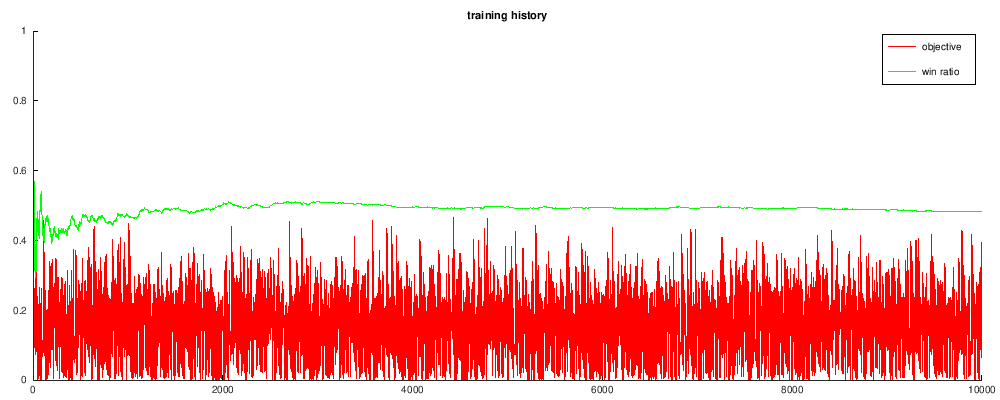

In [5]:
tau = 2;
printstart();
ratio = iteration(2, 10000);
printend(ipynb);

play(100, @randompolicy, @stochasticpolicy);
play(100, @randompolicy, @deterministicpolicy);

In [ ]:
%         if isempty(winner)
%             q = qnnestimate(s);
%         else
%             q = 0;
%         end
%         y          = zeros(9,1); 
%         y(prev_a)  = reward + gamma*q;

